In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 3
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 125 unqiue cards
Generated 7750 cardpairs
-- 3750 cardpairs with shared concept
-- 4000 cardpairs without shared concept
[(0, 4000), (1, 3000), (2, 750)]
Total number of matches =  108750
Number of shared concepts per match =  [(1, 105000), (2, 3750)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000001e-100, 860000), (9.195402298850577e-06, 108750)]

In [5]:
np.sum(count_table)

108750.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 61
xy_div_xyind_rank= 61


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

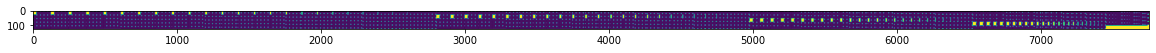

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

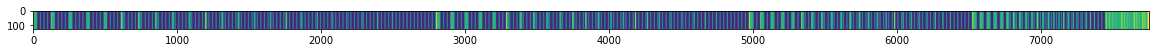

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

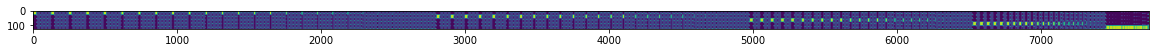

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

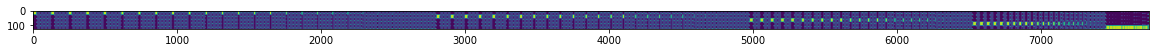

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(1.0000000000000018, 296000),
 (1.0000000000000016, 188000),
 (5.437500000000001e-95, 177600),
 (5.4375e-95, 112800),
 (5.000000000000001, 44400),
 (3.020833333333334e-95, 35520),
 (5.0, 28200),
 (3.020833333333333e-95, 24480),
 (2.7777777777777786, 19980),
 (1.0000000000000013, 16000),
 (2.7777777777777777, 12690),
 (5.437499999999999e-95, 9600),
 (4.999999999999999, 2400),
 (2.7777777777777772, 1080)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('re

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void'

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # classifier
    if hparams['classifier_nonlinearity'] == 'ReLU':
        classifier_non_linearity = nn.ReLU
    elif hparams['classifier_nonlinearity'] == 'Sigmoid':
        classifier_non_linearity = nn.Sigmoid
    else:
        raise ValueError('Unaccepted choice of nonlinearity')
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict(
                make_classifier(
                    scale_down_factor=hparams['classifier_layer_scaledown_factor'], 
                    d_model=hparams['d_model'],
                    non_linearity_class = classifier_non_linearity,
                )
            )
        ) if not hparams['dotproduct_bottleneck'] else None, 
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
def make_classifier(scale_down_factor, d_model, non_linearity_class):
    '''
    scale_down_factor: list e.g. [2,2,4]
    '''
    layer_lst = []
    last_dim = 2*d_model
    for i in range(len(scale_down_factor)):
        new_dim = int(2*d_model / scale_down_factor[i])
        layer_lst.append(('linear{}'.format(i), nn.Linear(last_dim, new_dim)))
        layer_lst.append(('Nonlinear{}'.format(i), non_linearity_class()))
        last_dim = new_dim
    layer_lst.append(('linear-out', nn.Linear(last_dim, 1)))
    
    return layer_lst

make_classifier([2,2,4], 48, nn.ReLU)

[('linear0', Linear(in_features=96, out_features=48, bias=True)),
 ('Nonlinear0', ReLU()),
 ('linear1', Linear(in_features=48, out_features=48, bias=True)),
 ('Nonlinear1', ReLU()),
 ('linear2', Linear(in_features=48, out_features=24, bias=True)),
 ('Nonlinear2', ReLU()),
 ('linear-out', Linear(in_features=24, out_features=1, bias=True))]

In [18]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [19]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        print(classifier)
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [20]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [21]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [22]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [23]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # classifier
    'classifier_nonlinearity': 'ReLU', # ReLU, Sigmoid
    'classifier_layer_scaledown_factor': [1,2], 
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 256,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':False,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;{}{}ClassifierLayers'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2), str(hparams['classifier_layer_scaledown_factor']), hparams['classifier_nonlinearity'])
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


Sequential(
  (linear0): Linear(in_features=512, out_features=512, bias=True)
  (Nonlinear0): ReLU()
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (Nonlinear1): ReLU()
  (linear-out): Linear(in_features=256, out_features=1, bias=True)
)
   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.4 M 
1  | model.inp_query_layer                        | Sequential         | 2.0 M 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.0 M 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.0 M 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 32.0 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 32.0 K
7  | model.inp_

## Run Training

In [24]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val5;epsilon1e-100;d_model256;params2410.24K;[1, 2]ReLUClassifierLayers exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-24-86fefc262d20>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 7750112 bytes
wandb: WARNING Serializing object of type ndarray that is 7750112 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.4 M 
1  | model.inp_query_layer                        | Sequential         | 2.0 M 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.0 M 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.0 M 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 32.0 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 32.0 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 32.0 K
8  | model.classifier                            

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=621, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=621, v_num=fxzf]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=618, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=619, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=619, v_num=fxzf]
Validating

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=611, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=611, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=611, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=611, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=610, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=610, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=610, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=610, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=610, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=593, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=593, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=592, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=592, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=592, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=591, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=591, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=591, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=591, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Validating: 0it [00:00, ?it/s]
Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=573, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=573, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=572, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=572, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=571, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=570, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=570, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=571, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=571, v_num=fxzf]
Validating

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=545, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=544, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=545, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=545, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=542, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=542, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=543, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=542, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=541, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=521, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=521, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=520, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=520, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=520, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=520, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=520, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=519, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=519, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=500, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=499, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=498, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=497, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=497, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=496, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=496, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=495, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=494, v_num=fxzf]
Validating

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=485, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=484, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=484, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=483, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=483, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=483, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=484, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=484, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=484, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=475, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=475, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=475, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=475, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=474, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=474, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=473, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=473, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=474, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=469, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=469, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=468, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=468, v_num=fxzf]
Validating

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=462, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=463, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=462, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=462, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=461, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=462, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=462, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=461, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=461, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=461, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=460, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=460, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=459, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=459, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=460, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=459, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=459, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=458, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=456, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=456, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=457, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=457, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=457, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=458, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=457, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=457, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=457, v_num=fxzf]
Validating

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=455, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=455, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=453, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=453, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=453, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=454, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=450, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=450, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=449, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=451, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=451, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=452, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=452, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=452, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=452, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=452, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=451, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=451, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1463:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=448, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2123:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2189:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2255:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=447, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2321:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2651: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2717:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2783:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=446, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2849:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2915:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2981:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3047:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3049:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3113:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3115:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3179:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3249:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3449:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3649:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3707:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3773:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3839:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=445, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  2.54it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4169:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=441, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4235:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4301:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=442, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4367:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=444, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=443, v_num=fxzf]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint...


Epoch 4371: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it, loss=443, v_num=fxzf]


[]

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [24]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '2qy0fxzf') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [26]:
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val5;epsilon1e-100;d_model256;params2410.24K;[1, 2]ReLUClassifierLayers exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-26-21237dfc373b>:22: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 7750112 bytes
wandb: WARNING Serializing object of type ndarray that is 7750112 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.4 M 
1  | model.inp_query_layer                        | Sequential         | 2.0 M 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.0 M 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.0 M 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 32.0 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 32.0 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 32.0 K
8  | model.classifier                            

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|████

Validating: 0it [00:00, ?it/s]
Epoch 68: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00

Epoch 101:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 110:

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=444, v_num=4j7i]
Validating

Epoch 168:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 170: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 177:

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Validating: 0it [00:00, ?it/s]
Epoch 235:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 236: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=445, v_num=4j7i]
Validating

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Epoch 301:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=448, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 310:

Validating: 0it [00:00, ?it/s]
Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=443, v_num=4j7i]
Validating

Epoch 368:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 369:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 370:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 371:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 372:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 373:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=448, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 374:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 375:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=447, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 377:

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 436:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 437:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 438:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 439:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 440:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 441:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=442, v_num=4j7i]
Validating

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Epoch 501:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 502:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 503:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 504:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 505:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 506:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 510:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=443, v_num=4j7i]
Validating

Epoch 568:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 569:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 570:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 571:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 577:

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Validating: 0it [00:00, ?it/s]
Epoch 635:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 636:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 637:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 638:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=442, v_num=4j7i]
Validating

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Epoch 701:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 702:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 703:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 704:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 710:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=446, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=444, v_num=4j7i]
Validating

Epoch 768:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 777:

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Validating: 0it [00:00, ?it/s]
Epoch 835:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 836:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 837:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 838:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=4j7i]
Validating

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=445, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Epoch 901:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 904:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 905:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 910:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=442, v_num=4j7i]
Validating

Epoch 968:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 969:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 970:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 971:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 972:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 973:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 977:

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1034:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1035:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1036:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1037:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1038:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1039:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1100:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1101:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1102:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1103:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1104:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1105:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1166:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1167:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1168:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1169:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1170:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1171:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1172: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1173:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1174:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1232:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1298:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1300:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1302:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1303:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1304:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1305:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1306:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1364:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1369:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1370:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1371:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1372:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1430:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1431:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1435:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1436:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1437:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1438: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1463: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1496:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1497:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1499: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1502:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1503:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1504:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1562:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1628:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1629:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1633:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1635:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1636:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1694:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1760:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1767:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1768:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1794: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1826:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1834:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1892:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1893:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1896:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1897:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1958:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1959:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1961:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1962:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1963:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2024:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2025:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2026:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2027:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2090:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2091:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2093:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2094:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2095:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2097:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2098:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2123:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2156:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2189:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2222:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2223:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2224:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2225:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2226:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2227:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2229:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2230:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2255:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2288:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2291:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2292:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2295:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2296:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2321:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2354:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2355:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2356:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2357:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2358:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2359:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2361:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2362:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2420:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2423:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2424:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2425:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2427:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2428:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2486:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2487:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2552:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2553:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2560:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2651:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2684:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2685:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2717:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2750:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2783:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2816:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2817:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2818:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2819:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2849: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2882:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2883:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2884:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2885:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2886:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2915:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2948:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2949: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2950:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2951:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 2981:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3014:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3015:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3016:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3017:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3018:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3019:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3021:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3022:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3047:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3049: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3080:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3113:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3115: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3146:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3147:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3148:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3149: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3150:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3151:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3153:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3154:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3179:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3212:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3215:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3216:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3217:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3219:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3220:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3278:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3279:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3280:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3281:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3282:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3283:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3285:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3344:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3345:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3346:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3348:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3349: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3351:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3352:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3410:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3411:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3412:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3476:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3477:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3478:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3482:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3483:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3484:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3542:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3608:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3609:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3610:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3615:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3616:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3649: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3674:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3681:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3682:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3707:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3740:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3741:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3742:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3747:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3748:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3773:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3806:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3807:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3808:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3813:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3814:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3839:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3872:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3873:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3874:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3875:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3938:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3939:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3940:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3941:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3942:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3943:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3945:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3946:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4004:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4070:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4071:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4072:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4077:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4078:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4136:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4144:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4169:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4202:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4203:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4204:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4235:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4268:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4269:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4270:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4271:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4275:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4301:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4334:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4335:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4336:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4337:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4367:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4400:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4401:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4402:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4403:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4404:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4405:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4407:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4408:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4433:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4434:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4435:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4466:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4499: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4500:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4501:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4532:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4533:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4534:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4535:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4536:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4537:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4538:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4539:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4540:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4565:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4566:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4567:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4598:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4601:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4602:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4603:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4604:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4605:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4606:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4631:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4632:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4664:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4665:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4666:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4667:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4668:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4669:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4670:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4671:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4672:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4697:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4698:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4699: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4730:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4731:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4732:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4733:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4734:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4735:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4736:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4737:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4738:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4763:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4796:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4797:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4798:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4799: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4829:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4830:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4831:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4862:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4863:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4864:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4865:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4866:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4867:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4868:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4869:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4870:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4895:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4896:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4897:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4928:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4936:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4961:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4962:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4963:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 4994:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4995:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4996:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4997:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4998:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5000:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5001:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5002:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5027:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5028:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5029:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5060:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5061:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5063:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5064:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5065:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5066:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5067:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5068:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5093:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5094:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5126:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5127:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5128:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5129:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5130:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5131:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5132:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5133:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5134:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5159:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5160:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5161:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5192:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5193:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5194:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5195:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5196:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5197:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5198:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5199: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5200:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5225:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5258:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5259:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5260:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5261:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5291:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5292:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5293:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5298:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5324:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5325:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5326:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5327:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5328:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5329:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5330:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5331:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5332:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5357:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5358:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5359:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5360:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5361:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5362:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5363:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5364:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5390:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5391:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5423:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5424:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5425:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5426:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5427:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5428:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5429:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5456:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5457:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5458:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5459:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5460:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5461:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5462:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5463:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5464:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5489:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5490:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5491:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5492:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5493:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5494:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5495:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5496:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5522:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5523:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5524:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5525:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5526:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5527:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5528:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5529:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5530:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5555:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5556:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5557:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5558:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5588:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5589:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5590:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5591:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5592:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5593:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5594:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5595:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5596:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5621:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5622:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5623:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5624:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5625:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5626:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5627:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5628:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5654:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5655:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5656:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5657:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5658:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5659:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5660:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5661:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5662:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5687:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5693:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5694:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5720:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5721:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5722:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5723:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5724:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5725:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5726:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5753:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5754:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5755:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5757:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5758:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5759:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5760:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5786:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5787:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5788:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5789:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5790:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5791:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5792:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5793:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5794:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5819:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5820:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5821:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5824:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5825:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5826:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5852:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5860:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5885:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5886:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5887:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5891:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5918:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5919:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5920:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5921:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5922:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5923:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5924:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5925:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5926:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5951:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5952:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5953:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5956:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 5984:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5985:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5987:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5988:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5989:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5990:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5991:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 5992:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6017:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6018:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6050:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6051:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6052:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6053:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6054:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6055:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6056:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6057:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6058:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6083:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6085:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6116:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6117:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6118:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6119:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6120:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6121:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6122:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6123:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6124:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6149:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6182:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6183:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6184:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6215:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6216:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6217:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6248:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6249:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6250:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6255:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6256:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6281:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6282:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6283:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6314:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6347:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6348:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6349:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6380:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6381:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6382:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6383:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6384:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6385:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6386:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6387:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6413:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6414:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6415:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6446:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6447:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6448:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6449:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6450:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6451:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6452:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6453:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6454:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6479:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6480:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6481:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6482:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6512:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6513:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6514:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6515:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6516:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6517:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6518:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6519:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6520:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6545:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6546:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6547:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6548:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6549:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6578:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6579:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6580:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6581:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6582:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6583:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6584:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6585:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6586:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6611:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6617:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6618:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6644:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6645:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6646:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6647:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6648:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6649:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6650:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6677:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6678:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6679:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6680:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6681:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6682:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6683:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6684:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6685:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6710:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6711:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6712:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6713:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6714:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6715:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6716:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6717:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6718:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6743:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6744:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6745:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6746:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6747:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6748:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6749:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6750:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6751:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6776:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6777:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6784:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6809:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6810:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6811:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6812:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6813:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6814:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6815:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6842:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6843:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6844:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6845:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6846:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6847:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6848:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6849:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6850:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6875:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6876:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6877:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6878:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6879:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6880:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6881:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6882:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6883:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6908:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6909:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6910:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6911:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6912:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6913:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6914:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6915:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6916:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6941:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6942:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6943:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6949:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 6974:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6975:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6976:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6977:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6978:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6979:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6980:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6981:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 6982:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7007:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7008:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7009:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7010:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7011:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7013:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7014:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7015:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7040:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7041:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7042:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7043:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7044:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7045:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7046:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7047:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7048:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7073:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7079:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7080:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7081: 100%|██████████| 2/2 [00:00<00:00,  7.12it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7106:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7107:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7108:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7109:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7110:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7139:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7140:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7141:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7142:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7172:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7173:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7174:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7175:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7176:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7177:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7178:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7179:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7180:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7205:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7206:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7207:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7208:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7238:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7239:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7240:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7271:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7272:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7273:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7274:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7304:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7305:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7306:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7307:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7308:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7309:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7310:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7311:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7312:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7337:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7338:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7339:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7340:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7370:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7371:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7372:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7373:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7374:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7375:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7376:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7377:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7378:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7403:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7404:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7405:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7436:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7437:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7438:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7439:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7440:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7441:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7442:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7443:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7444:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7469:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7470:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7471:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7472:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7473:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7474:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7475:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7476:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7477:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7502:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7503:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7504:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7505:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7506:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7507:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7508:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7509:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7510:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7535:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7540:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7541:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7542:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7543:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7568:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7569:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7570:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7571:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7572:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7573:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7574:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7601:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7602:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7603:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7604:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7605:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7606:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7607:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7608:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7609:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7634:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7635:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7636:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7637:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7638:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7639:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7640:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7641:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7642:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7667:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7668:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7669:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7670:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7671:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7672:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7673:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7674:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7675:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7700:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7701:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7702:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7706:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7707:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7708:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7733:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7734:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7735:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7736:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7737:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7738:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7739:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7740:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7741:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7766:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7767:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7768:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7769:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7770:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7771:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7772:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7773:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7774:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7799:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7800:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7801:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7802:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7803:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7804:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7805:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7806:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7807:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7832:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7833:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7834:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7835:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7836:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7837:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7838:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7839:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7840:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7865:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7866:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7867:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7898:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7899:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7900:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7901:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7902:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7903:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7904:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7905:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7906:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7931:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7932:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7933:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7934:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7935:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7936:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7937:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7938:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7939:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7964:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7965:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7966:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7967:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7968:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7969:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7970:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7971:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7972:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 7997:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 7999:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8002:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8003:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8004:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8005:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8030:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8031:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8032:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8033:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8034:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8035:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8063:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8064:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8065:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8066:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8067:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8068:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8069:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8070:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8071:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8096:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8097:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8098:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8099:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8100:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8101:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8102:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8103:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8104:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8129:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8130:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8131:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8132:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8133:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8134:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8135:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8136:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8137:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8162:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8168:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8169:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8170:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8195:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8196:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8197:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8198:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8199:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8200:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8201:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8202:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8203:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8228:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8229:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8230:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8231:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8232:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8233:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8234:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8235:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8236:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8261:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8262:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8263:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8264:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8265:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8266:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8267:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8268:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8269:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8294:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8295:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8296:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8297:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8298:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8299:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8300:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8301:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8302:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8327:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8328:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8360:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8361:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8362:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8363:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8364:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8365:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8366:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8367:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8368:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8393:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8394:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8395:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8396:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8397:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8398:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8399:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8400:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8401:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8426:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8427:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8428:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8429:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8430:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8431:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8432:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8433:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8434:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8459:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8464:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8465:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8466:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8467:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8492:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8493:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8494:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8495:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8496:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8497:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8499:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8525:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8528:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8529:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8530:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8531:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8532:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8533:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8558:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8559:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8560:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8561:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8562:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8563:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8564:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8565:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8566:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8591:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8592:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8594:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8595:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8596:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8597:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8598:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8599:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8624:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8632:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8657:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8658:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8662:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8663:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8690:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8691:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8692:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8693:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8694:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8695:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8696:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8697:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8698:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8723:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8724:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8725:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8729:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8731:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8756:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8757:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8758:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8759:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8760:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8761:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8762:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8763:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8764:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8789:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8790:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8791:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8822:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8823:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8824:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8825:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8826:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8827:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8828:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8829:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8830:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8855:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8856:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8857:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8858:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8863:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8888:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8889:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8890:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8891:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8892:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8893:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8894:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8895:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8896:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8921:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=444, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8954:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8955:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8956:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8957:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8958:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 8987:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8988:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8989:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8990:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8991:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9020:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9021:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9022:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9023:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9024:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9025:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9026:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9027:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9028:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9053:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9054:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9055:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9056:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9057:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9058:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9086:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9087:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9088:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9089:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9119:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9120:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9121:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9122:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9123:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9124:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9152:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9153:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9154:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9155:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9156:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9157:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9158:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9159:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9160:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9185:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9186:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9187:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9188:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9189:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9190:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9191:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9218:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9219:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9220:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9221:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9222:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9223:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9224:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9225:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9226:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9251:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9252:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9253:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9254:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9284:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9285:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9286:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9287:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9288:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9289:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9290:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9291:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9292:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9317:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9318:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9319:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9320:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9321:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9322:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9323:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9324:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9350:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9351:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9352:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9353:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9354:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9355:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9356:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9357:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9358:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9383:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9385:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9386:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9387:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9388:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9389:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9390:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9416:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9417:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9418:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9419:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9420:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9421:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9422:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9423:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9449:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9450:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9451:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9452:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9453:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9454:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9455:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9456:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9457:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9482:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9483:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9484:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9485:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9486:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9487:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9488:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9489:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9490:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9515:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9516:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9517:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9518:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9519:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9520:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9521:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9522:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9523:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9548:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9549:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9550:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9551:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9552:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9553:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9554:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9555:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9556:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9581:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9582:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9583:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9584:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9585:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9586:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9587:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9588:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9589:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9614:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9615:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9616:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9617:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9618:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9619:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9620:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9621:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9622:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9647:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9648:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9649:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9650:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9651:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9652:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9653:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9654:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9655:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9680:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9681:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9682:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9683:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9684:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9685:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9686:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9687:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9688:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9713:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9714:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9715:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9719:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9746:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9747:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9748:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9749:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9750:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9751:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9752:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9753:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9754:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9779:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9780:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9781:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9782:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9783:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9784:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9785:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9786:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9787:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9812:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9813:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9814:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9815:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9816:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9817:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9818:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9819:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9820:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9845:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9848:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9849:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9850:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9851:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9852:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9853:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9878:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9879:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9880:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9881:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9882:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9883:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9884:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9885:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9886:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9911:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9912:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9913:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9914:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9915:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9916:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9917:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9918:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9919:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9944:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9945:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9946:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9947:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9948:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9949:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9950:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9951:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9952:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 9977:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9978:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9979:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9980:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9981:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9982:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9983:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9984:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 9985:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
E

Epoch 10010:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10011:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10012:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10013:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10014:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10015:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10016:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10017:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10018:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10043:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10044:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10045:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10046:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10047:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10048:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10049:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10050:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10051:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10076:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10077:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10078:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10079:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10080:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10081:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10082:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10083:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10084:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10109:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10110:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10111:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10112:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10113:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10114:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10115:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10116:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10117:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=439, v_nu

Epoch 10141:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10142:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10143:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10144:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10145:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10146:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10147:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10148:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10149:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10174:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10175:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10176:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10179:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10182:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10207:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10208:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10209:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10210:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10211:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10212:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10213:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10214:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10215:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10240:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10241:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10242:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10243:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10244:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10245:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10246:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10247:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10248:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=441, v_nu

Epoch 10272:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10273:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10274:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10275:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10276:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10277:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10278:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10279:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10280:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10305:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10306:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10307:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10308:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10309:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10310:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10311:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10312:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10313:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10338:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10339:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10340:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10341:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10342:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10343:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10344:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10345:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10346:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10371:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10372:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10373:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10374:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10375:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10376:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10377:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10378:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10379:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_nu

Epoch 10403:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10404:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10405:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10406:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10407:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10408:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10409:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10410:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10411:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10436:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10437:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10438:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10439:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10440:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10441:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10442:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10443:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10444:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10469:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10470:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10471:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10472:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10473:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10474:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10475:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10476:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10477:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10502:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10503:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10504:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10505:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10506:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10507:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10508:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10509:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_nu

Epoch 10534:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10535:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10536:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10537:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10538:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10539:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10540:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10541:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10542:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10567:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10568:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10569:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10570:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10571:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10572:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10573:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10574:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10575:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10600:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10601:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10602:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10603:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10604:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10605:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10606:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10607:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10608:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10640:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10641:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=439, v_nu

Epoch 10665:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10666:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10667:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10668:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10669:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10670:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10671:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10672:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10673:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10698:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10699:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10700:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10701:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10702:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10703:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10704:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10705:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10706:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10731:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10732:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10733:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10734:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10735:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10736:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10737:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10738:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10739:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10764:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10765:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10766:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10767:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10768:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10769:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10770:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10771:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10772:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_nu

Epoch 10796:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10797:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10798:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10799:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10800:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10801:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10802:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10803:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10804:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10829:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10830:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10831:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10832:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10833:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10834:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10835:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10836:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10837:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10862:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10863:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10864:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10865:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10866:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10867:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10868:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10869:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10870:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10895:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10896:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10897:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10898:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10899:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10900:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10901:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10902:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10903:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=441, v_nu

Epoch 10927:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10928:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10929:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10930:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10931:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10932:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10933:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10934:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10935:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10960:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10961:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10962:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10963:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10964:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10967:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10968:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 10993:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10994:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10995:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10996:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10997:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10998:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 10999:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11000:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11001:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11026:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11027:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11028:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11029:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11030:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11031:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11032:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11033:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11034:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_nu

Epoch 11058:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11059:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11060:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11061:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11062:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11063:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11064:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11065:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11066:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11091:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11092:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11093:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11095:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11096:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11097:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11098:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11099:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11124:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11125:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11126:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11127:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11128:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11129:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11130:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11131:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11132:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11157:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11158:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11159:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11160:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11161:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11162:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11163:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11164:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11165:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_nu

Epoch 11189:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11190:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11191:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11192:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11193:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11194:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11195:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11196:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11197:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11222:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11223:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11224:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11225:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11226:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11227:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11228:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11229:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11230:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11255:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11256:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11259:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11261:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11262:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11263:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11288:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11289:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11290:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11291:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11292:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11293:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11294:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11295:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_nu

Epoch 11320:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11321:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11322:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11323:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11324:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11325:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11326:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11327:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11328:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11353:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11354:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11355:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11356:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11357:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11358:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11359:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11360:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11361:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11386:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11387:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11388:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11389:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11390:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11391:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11392:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11393:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11394:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11419:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11420:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11421:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11425:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=438, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11427:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=439, v_nu

Epoch 11451:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11452:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11453:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11454:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11455:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11456:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11457:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11458:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11459:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11484:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11485:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11486:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11487:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11488:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11489:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11490:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11491:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11492:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11517:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11518:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11519:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11520:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11521:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11522:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11523:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11524:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11525:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11553:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11554:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11555:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11556:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11557:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11558:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_nu

Epoch 11582:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11583:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11584:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11585:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11586:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11587:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11588:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11589:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11590:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11615:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11616:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11617:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11618:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11619:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11620:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11621:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11622:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11623:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11648:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11649:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11650:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11651:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11652:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11653:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11654:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11655:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11656:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11681:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11682:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11683:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11684:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11685:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11686:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11687:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11688:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11689:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_nu

Epoch 11713:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11715:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11717:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11718:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11719:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11720:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11721:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=439, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11746:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11747:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11748:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11749:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11750:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11752:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11753:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11754:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11779:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11780:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11781:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11782:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11783:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11784:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11785:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11786:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11787:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11812:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11813:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11814:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11815:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11816:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11817:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11818:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11819:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11820:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_nu

Epoch 11844:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11845:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11846:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11847:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11848:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11849:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11850:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11851:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11852:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11877:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11884:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11885:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Epoch 11910:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11911:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11912:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=443, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11913:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11914:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11915:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11916:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11917:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11918:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11943:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11944:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11945:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11946:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11947:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11948:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11949:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11950:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=440, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11951:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=440, v_nu

Epoch 11975:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=441, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11976:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11977:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11978:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11979:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11980:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11981:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11982:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00, ?it/s]
Epoch 11983:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=442, v_num=4j7i]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 11999: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s, loss=443, v_num=4j7i]


[]

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'epoch=1742-val_loss=415.10.ckpt') # best
run_PATH = os.path.join(project_name, '2qy0fxzf') # also from wandb interface

# wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])